# QF 627 Programming and Computational Finance
## Lesson 06 | Predictive Models with Machine Learning `Part 2`

> Hi, Team 👋 

> Last week, we built our basic understanding of predictive modeling. Now we will move beyond the basics and learn more by solving problems. This will be informative and, more importantly, fun to learn.

> The cross-disciplinary field of quantitative and computational finance cannot easily be learned by merely reading books and going through random demonstrations of programming. It should be learning-by-doing, with systematic guidance on case studies. This is one of the best ways to learn and to build your expertise in quantitative and computational finance, as I have said many times throughout the semester.

> After learning the basics of how to predict market direction with deep neural networks, we will move on to learning about machine learning (pun intended here) through solving problems. As a test case, we will attempt to predict Microsoft’s stock price.

## DEPENDENCIES

In [1]:
# Load libraries.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import time

import datetime as dt
import re

import plotly.express as px

import pandas_datareader.data as web
from pandas_datareader import data as pdr

import yfinance as yf

(
    yf
    .pdr_override()
)

import warnings
warnings.filterwarnings("ignore")

# Setting baseline seed
np.random.seed(230926)

# Set print options.

np.set_printoptions(precision = 3)

plt.style.use("ggplot") # Grammar of Graphics Theme

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline

## 👉 <a id = "top">Learning Pointers</a> 👈 

## [1. Problem Statement and Dependencies for Supervised ML](#p1)

> ### <font color = red> Define and Import </font>

## [2. Wrangle & Prepare Input Features](#p2)

> ### <font color = red> Feature Engineering </font>

## [3. Supervised Machine Learning: Step-by-Step](#p3)

> ### <font color = red> There are five steps </font>

## [4. A First Look at Hyperparameter Tuning](#p4)

> ### <font color = red> Tune `p`,`d`,`q` in ARIMA </font>

## [5. What We Have Learned Thus Far...](#p5)

> ### <font color = red> Supervised Learning for Price Prediction </font>


## <a id = "p1">1. </a> <font color = "green"> Problem Statement & Dependencies for Supervised ML </font>  [back to table of contents](#top)

> We will create a predictive model for the weekly return of MSFT stock. 

> To solve the problem, it is essential to understand what affects Microsoft’s stock price and to incorporate as much information as we can into the model. 

> Among correlated assets, technical indicators, and fundamental analysis, we will concentrate on correlated assets as features here.

### Activate Necessary Packages

> For the supervised regression models

In [2]:
# Loading Algorithm

from sklearn.linear_model import LinearRegression

# Regularization
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# ENSEMBLE

## Bagging
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

## Boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Support Vector Machine
from sklearn.svm import SVR

# K-Nearest Neighbor
from sklearn.neighbors import KNeighborsRegressor

# Multi-layer Perceptron (Neural Networks)
from sklearn.neural_network import MLPRegressor

> For data analysis and model evaluation

In [3]:
# for data split
from sklearn.model_selection import train_test_split

# for cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# for assessment
from sklearn.metrics import mean_squared_error

# for Feature Selection
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

> For time series models

In [4]:
import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

> For data preparation and visualization

In [5]:
from pandas.plotting import scatter_matrix

# for Pre-processing (Feature Engineering)
from sklearn.preprocessing import StandardScaler

# assumption checks for Time-Series
from statsmodels.graphics.tsaplots import plot_acf

### IMPORT Data

> In addition to historical data on Microsoft, the independent variables used are the following potentially correlated assets.

- Stocks
IBM (IBM) and Alphabet (GOOGL)

- Currency
USD/JPY and GBP/USD

- Indices
S&P 500, Dow Jones, and VIX

In [6]:
stock_ticker = ["MSFT", "IBM", "GOOGL"]

currency_ticker = ["DEXJPUS", "DEXUSUK"]

index_ticker = ["SP500", "DJIA", "VIXCLS"]


stock_data = pdr.get_data_yahoo(stock_ticker)
currency_data = pdr.get_data_fred(currency_ticker)
index_data = pdr.get_data_fred(index_ticker)

[*********************100%%**********************]  3 of 3 completed


In [7]:
stock_data

Adj Close                               Close              \
                 GOOGL         IBM        MSFT       GOOGL         IBM   
Date                                                                     
1962-01-02         NaN    1.573410         NaN         NaN    7.291268   
1962-01-03         NaN    1.587165         NaN         NaN    7.355003   
1962-01-04         NaN    1.571347         NaN         NaN    7.281708   
1962-01-05         NaN    1.540401         NaN         NaN    7.138305   
1962-01-08         NaN    1.511519         NaN         NaN    7.004461   
...                ...         ...         ...         ...         ...   
2023-10-19  137.750000  138.009995  331.320007  137.750000  138.009995   
2023-10-20  135.600006  137.160004  326.670013  135.600006  137.160004   
2023-10-23  136.500000  136.380005  329.320007  136.500000  136.380005   
2023-10-24  138.809998  137.789993  330.529999  138.809998  137.789993   
2023-10-25  127.690002  137.744995  345.970001  127.690002  137.744995   

                              High                                 Low  \
                  MSFT       GOOGL         IBM        MSFT       GOOGL   
Date                                                                     
1962-01-02         NaN         NaN    7.374124         NaN         NaN   
1962-01-03         NaN         NaN    7.355003         NaN         NaN   
1962-01-04         NaN         NaN    7.355003         NaN         NaN   
1962-01-05         NaN         NaN    7.272148         NaN         NaN   
1962-01-08         NaN         NaN    7.131931         NaN         NaN   
...                ...         ...         ...         ...         ...   
2023-10-19  331.320007  139.660004  139.410004  336.880005  137.380005   
2023-10-20  326.670013  137.869995  139.270004  331.920013  135.080002   
2023-10-23  329.320007  137.660004  137.679993  332.730011  133.949997   
2023-10-24  330.529999  139.360001  137.979996  331.839996  137.419998   
2023-10-25  345.970001  128.199997  137.789993  346.200012  126.699997   

                                          Open                          \
                   IBM        MSFT       GOOGL         IBM        MSFT   
Date                                                                     
1962-01-02    7.291268         NaN         NaN    7.374124         NaN   
1962-01-03    7.291268         NaN         NaN    7.291268         NaN   
1962-01-04    7.278521         NaN         NaN    7.355003         NaN   
1962-01-05    7.125558         NaN         NaN    7.272148         NaN   
1962-01-08    6.947100         NaN         NaN    7.131931         NaN   
...                ...         ...         ...         ...         ...   
2023-10-19  137.929993  330.910004  138.500000  138.639999  332.149994   
2023-10-20  137.119995  325.450012  137.330002  138.149994  331.720001   
2023-10-23  135.869995  324.390015  135.039993  136.630005  325.470001   
2023-10-24  136.050003  327.600006  137.830002  136.740005  331.299988   
2023-10-25  137.500000  344.500000  137.830002  136.740005  331.299988   

                Volume                       
                 GOOGL      IBM        MSFT  
Date                                         
1962-01-02         NaN   407940         NaN  
1962-01-03         NaN   305955         NaN  
1962-01-04         NaN   274575         NaN  
1962-01-05         NaN   384405         NaN  
1962-01-08         NaN   572685         NaN  
...                ...      ...         ...  
2023-10-19  26066000.0  5314200  25052100.0  
2023-10-20  26315200.0  4865300  25012600.0  
2023-10-23  26317900.0  3457500  24374700.0  
2023-10-24  44394300.0  3697200  30444300.0  
2023-10-25   5957976.0    66994   3298209.0  

[15561 rows x 18 columns]

In [8]:
currency_data

,DEXJPUS,DEXUSUK
DATE,,
2018-10-26,111.65,1.2826
2018-10-29,112.49,1.2807
2018-10-30,112.76,1.2731
2018-10-31,112.86,1.2779
2018-11-01,112.79,1.2974
...,...,...
2023-10-16,149.57,1.2198
2023-10-17,149.71,1.2206
2023-10-18,149.86,1.2150


In [9]:
index_data

,SP500,DJIA,VIXCLS
DATE,,,
2018-10-26,2658.69,24688.31,24.16
2018-10-29,2641.25,24442.92,24.70
2018-10-30,2682.63,24874.64,23.35
2018-10-31,2711.74,25115.76,21.23
2018-11-01,2740.37,25380.74,19.34
...,...,...,...
2023-10-18,4314.60,33665.08,19.22
2023-10-19,4278.00,33414.17,21.40
2023-10-20,4224.16,33127.28,21.71


## <a id = "p2">2. </a> <font color = "green"> Wrangle and Prepare Input Features </font>  [back to table of contents](#top)

### Data Transformation

> Next, we define our outcome (Y) and predictor (X) variables. The outcome variable is the weekly return of MSFT. The predicted variable is the weekly return of Microsoft (MSFT). 

> The number of trading days in a week is assumed to be five, and we compute the return using five trading days. For predictor variables we use the correlated assets and the historical return of MSFT at different frequencies.

> The variables used as predictors are lagged five-day returns of stocks (IBM and GOOG), currency exchange rates (USD/JPY and GBP/USD), and indices (S&P 500, Dow Jones, and VIX), along with lagged five-day, 15-day, 30-day, and 60-day returns of MSFT.

> The lagged five-day variables embed the time series component by using a time-delay approach, where the lagged variable is included as one of the predictor variables. This step translates the time series data into a supervised regression-based model framework.

In [10]:
return_period = 5

### Outcome (Y)

In [11]:
stock_data

Adj Close                               Close              \
                 GOOGL         IBM        MSFT       GOOGL         IBM   
Date                                                                     
1962-01-02         NaN    1.573410         NaN         NaN    7.291268   
1962-01-03         NaN    1.587165         NaN         NaN    7.355003   
1962-01-04         NaN    1.571347         NaN         NaN    7.281708   
1962-01-05         NaN    1.540401         NaN         NaN    7.138305   
1962-01-08         NaN    1.511519         NaN         NaN    7.004461   
...                ...         ...         ...         ...         ...   
2023-10-19  137.750000  138.009995  331.320007  137.750000  138.009995   
2023-10-20  135.600006  137.160004  326.670013  135.600006  137.160004   
2023-10-23  136.500000  136.380005  329.320007  136.500000  136.380005   
2023-10-24  138.809998  137.789993  330.529999  138.809998  137.789993   
2023-10-25  127.690002  137.744995  345.970001  127.690002  137.744995   

                              High                                 Low  \
                  MSFT       GOOGL         IBM        MSFT       GOOGL   
Date                                                                     
1962-01-02         NaN         NaN    7.374124         NaN         NaN   
1962-01-03         NaN         NaN    7.355003         NaN         NaN   
1962-01-04         NaN         NaN    7.355003         NaN         NaN   
1962-01-05         NaN         NaN    7.272148         NaN         NaN   
1962-01-08         NaN         NaN    7.131931         NaN         NaN   
...                ...         ...         ...         ...         ...   
2023-10-19  331.320007  139.660004  139.410004  336.880005  137.380005   
2023-10-20  326.670013  137.869995  139.270004  331.920013  135.080002   
2023-10-23  329.320007  137.660004  137.679993  332.730011  133.949997   
2023-10-24  330.529999  139.360001  137.979996  331.839996  137.419998   
2023-10-25  345.970001  128.199997  137.789993  346.200012  126.699997   

                                          Open                          \
                   IBM        MSFT       GOOGL         IBM        MSFT   
Date                                                                     
1962-01-02    7.291268         NaN         NaN    7.374124         NaN   
1962-01-03    7.291268         NaN         NaN    7.291268         NaN   
1962-01-04    7.278521         NaN         NaN    7.355003         NaN   
1962-01-05    7.125558         NaN         NaN    7.272148         NaN   
1962-01-08    6.947100         NaN         NaN    7.131931         NaN   
...                ...         ...         ...         ...         ...   
2023-10-19  137.929993  330.910004  138.500000  138.639999  332.149994   
2023-10-20  137.119995  325.450012  137.330002  138.149994  331.720001   
2023-10-23  135.869995  324.390015  135.039993  136.630005  325.470001   
2023-10-24  136.050003  327.600006  137.830002  136.740005  331.299988   
2023-10-25  137.500000  344.500000  137.830002  136.740005  331.299988   

                Volume                       
                 GOOGL      IBM        MSFT  
Date                                         
1962-01-02         NaN   407940         NaN  
1962-01-03         NaN   305955         NaN  
1962-01-04         NaN   274575         NaN  
1962-01-05         NaN   384405         NaN  
1962-01-08         NaN   572685         NaN  
...                ...      ...         ...  
2023-10-19  26066000.0  5314200  25052100.0  
2023-10-20  26315200.0  4865300  25012600.0  
2023-10-23  26317900.0  3457500  24374700.0  
2023-10-24  44394300.0  3697200  30444300.0  
2023-10-25   5957976.0    66994   3298209.0  

[15561 rows x 18 columns]

In [12]:
Y =\
    (np
     .log(stock_data.loc[ : , ("Adj Close", "MSFT")]
         )
     .diff(return_period)
     .shift(-return_period)
    )

Y

Date
1962-01-02   NaN
1962-01-03   NaN
1962-01-04   NaN
1962-01-05   NaN
1962-01-08   NaN
              ..
2023-10-19   NaN
2023-10-20   NaN
2023-10-23   NaN
2023-10-24   NaN
2023-10-25   NaN
Name: (Adj Close, MSFT), Length: 15561, dtype: float64

In [13]:
Y.name =\
    (Y
     .name[-1]
     +
     "_pred")

Y

Date
1962-01-02   NaN
1962-01-03   NaN
1962-01-04   NaN
1962-01-05   NaN
1962-01-08   NaN
              ..
2023-10-19   NaN
2023-10-20   NaN
2023-10-23   NaN
2023-10-24   NaN
2023-10-25   NaN
Name: MSFT_pred, Length: 15561, dtype: float64

### Input Features (Xs)

In [14]:
X1 =\
    (np.
     log(stock_data.loc[ : , ("Adj Close", ("GOOGL", "IBM")
                             )
                       ]
        )
     .diff(return_period)
    )

X1.columns =\
    (X1
     .columns
     .droplevel()
    )

X1

,GOOGL,IBM
Date,,
1962-01-02,NaN,NaN
1962-01-03,NaN,NaN
1962-01-04,NaN,NaN
1962-01-05,NaN,NaN
1962-01-08,NaN,NaN
...,...,...
2023-10-19,-0.008818,-0.023135
2023-10-20,-0.012896,-0.009433
2023-10-23,-0.018869,-0.020538


In [15]:
currency_data

,DEXJPUS,DEXUSUK
DATE,,
2018-10-26,111.65,1.2826
2018-10-29,112.49,1.2807
2018-10-30,112.76,1.2731
2018-10-31,112.86,1.2779
2018-11-01,112.79,1.2974
...,...,...
2023-10-16,149.57,1.2198
2023-10-17,149.71,1.2206
2023-10-18,149.86,1.2150


In [16]:
X2 =\
    (np
     .log(currency_data)
     .diff(return_period)
    )

X2

,DEXJPUS,DEXUSUK
DATE,,
2018-10-26,NaN,NaN
2018-10-29,NaN,NaN
2018-10-30,NaN,NaN
2018-10-31,NaN,NaN
2018-11-01,NaN,NaN
...,...,...
2023-10-16,NaN,NaN
2023-10-17,0.007307,-0.006696
2023-10-18,0.004615,-0.012595


> Team, FYI, after the logarithmic transformation, 
> the .diff(return_period) function is called on the resulting DataFrame. 

> This calculates the difference of consecutive log values (log-return) with a specified lag equal to return_period. 

> The return_period is a parameter representing the number of periods (rows) over which the difference is calculated.

In [17]:
X3 =\
    (np
     .log(index_data)
     .diff(return_period)
    )

X3

,SP500,DJIA,VIXCLS
DATE,,,
2018-10-26,NaN,NaN,NaN
2018-10-29,NaN,NaN,NaN
2018-10-30,NaN,NaN,NaN
2018-10-31,NaN,NaN,NaN
2018-11-01,NaN,NaN,NaN
...,...,...,...
2023-10-18,-0.014348,-0.004144,0.177753
2023-10-19,-0.016601,-0.006472,0.248581
2023-10-20,-0.024234,-0.016259,0.116632


> For each value i in the list [return_period, return_period * 3, return_period * 6, return_period * 12], 
> let's calculates the logarithm of the values in column ("Adj Close", "MSFT") 
> of DataFrame stock_data, 
> and then calculates the difference of consecutive log values (log-return) with lag i. 

> This results in a list of DataFrames.


> The DataFrames from the list comprehension are concatenated along the columns (axis=1),
> creating a single DataFrame. 

> After concatenation, rows containing any NaN values are dropped using .dropna().

In [18]:
X4 =\
    (
    pd
    .concat([np
             .log(stock_data.loc[ : , ("Adj Close", "MSFT")
                                ]
                 )
             .diff(i) for i in [return_period, 
                                return_period * 3, 
                                return_period * 6, 
                                return_period * 12]
            ],
           axis = 1
           )
    .dropna()
)

X4.columns = ["MSFT_DT", "MSFT_3DT", "MSFT_6DT", "MSFT_12DT"]

In [19]:
X4

,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
Date,,,,
1986-06-09,-0.037464,0.015384,-0.030084,0.156698
1986-06-10,-0.037464,0.031008,-0.037464,0.121609
1986-06-11,-0.030084,0.038913,-0.007604,0.104506
1986-06-12,-0.083702,0.016000,-0.023529,0.091354
1986-06-13,-0.083702,0.016000,-0.007904,0.108897
...,...,...,...,...
2023-10-19,0.000483,0.054839,0.004265,-0.017165
2023-10-20,-0.003240,0.034000,-0.022998,-0.010207
2023-10-23,-0.010031,0.023100,-0.025838,-0.024995


In [20]:
X=\
(
    pd
    .concat([X1, X2, X3, X4],
            axis = 1)
)

X

,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
1962-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-19,-0.008818,-0.023135,0.001402,-0.005665,-0.016601,-0.006472,0.248581,0.000483,0.054839,0.004265,-0.017165
2023-10-20,-0.012896,-0.009433,0.001536,0.001153,-0.024234,-0.016259,0.116632,-0.003240,0.034000,-0.022998,-0.010207
2023-10-23,-0.018869,-0.020538,NaN,NaN,-0.036460,-0.031327,0.168573,-0.010031,0.023100,-0.025838,-0.024995
2023-10-24,-0.006534,-0.018195,NaN,NaN,-0.029122,-0.025509,NaN,-0.004618,0.053249,-0.003745,-0.014061


> Let's concatenate two DataFrames Y and X along the columns, 
> dropping any rows with missing values, 
> and then selecting rows 
> at regular intervals specified by return_period. 

In [21]:
data =\
(
pd
.concat([Y, X],
        axis = 1)
.dropna()
.iloc[ : :return_period, :]
)

In [22]:
# MAXIM to keep in mind: Garbage in , Garbage out!

data

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2018-11-02,0.031616,-0.011377,-0.075891,0.012815,0.010779,0.023923,0.023321,-0.213771,-0.007508,-0.031616,-0.073529,-0.028687
2018-11-09,-0.007440,0.005148,0.078480,0.005995,0.001002,0.021058,0.028034,-0.116758,0.031616,0.008340,-0.042875,0.017771
2018-11-20,0.088485,-0.016859,-0.030586,-0.011561,-0.017183,-0.029938,-0.033001,0.115894,-0.045832,-0.015355,-0.094381,-0.070401
2018-11-28,-0.017521,0.057823,0.048302,0.007929,-0.000783,0.034807,0.036196,-0.117723,0.088485,0.035386,0.005391,-0.000985
2018-12-07,0.011477,-0.044843,-0.017773,-0.008313,-0.001802,-0.047138,-0.046055,0.251191,-0.049961,-0.001430,0.028450,-0.059351
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-15,-0.040826,0.007451,-0.011510,0.000880,-0.006756,-0.001610,0.001204,-0.003619,-0.012190,0.031532,0.012954,-0.007949
2023-09-22,-0.003983,-0.053441,0.006282,0.002770,-0.010954,-0.029707,-0.019084,0.220966,-0.040826,-0.033348,-0.016387,-0.055616
2023-09-29,0.035804,0.004672,-0.046037,0.007995,-0.003514,-0.007437,-0.013527,0.018434,-0.003983,-0.056998,-0.003572,-0.075608
2023-10-06,0.001435,0.050078,0.012255,-0.002345,0.003351,0.004758,-0.002986,-0.004003,0.035804,-0.009004,0.022528,-0.043869


In [23]:
Y = data.loc[ : , Y.name]

Y

2018-11-02    0.031616
2018-11-09   -0.007440
2018-11-20    0.088485
2018-11-28   -0.017521
2018-12-07    0.011477
                ...   
2023-09-15   -0.040826
2023-09-22   -0.003983
2023-09-29    0.035804
2023-10-06    0.001435
2023-10-17   -0.004618
Name: MSFT_pred, Length: 235, dtype: float64

In [24]:
X = data.loc[ : , X.columns]

X

,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2018-11-02,-0.011377,-0.075891,0.012815,0.010779,0.023923,0.023321,-0.213771,-0.007508,-0.031616,-0.073529,-0.028687
2018-11-09,0.005148,0.078480,0.005995,0.001002,0.021058,0.028034,-0.116758,0.031616,0.008340,-0.042875,0.017771
2018-11-20,-0.016859,-0.030586,-0.011561,-0.017183,-0.029938,-0.033001,0.115894,-0.045832,-0.015355,-0.094381,-0.070401
2018-11-28,0.057823,0.048302,0.007929,-0.000783,0.034807,0.036196,-0.117723,0.088485,0.035386,0.005391,-0.000985
2018-12-07,-0.044843,-0.017773,-0.008313,-0.001802,-0.047138,-0.046055,0.251191,-0.049961,-0.001430,0.028450,-0.059351
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-15,0.007451,-0.011510,0.000880,-0.006756,-0.001610,0.001204,-0.003619,-0.012190,0.031532,0.012954,-0.007949
2023-09-22,-0.053441,0.006282,0.002770,-0.010954,-0.029707,-0.019084,0.220966,-0.040826,-0.033348,-0.016387,-0.055616
2023-09-29,0.004672,-0.046037,0.007995,-0.003514,-0.007437,-0.013527,0.018434,-0.003983,-0.056998,-0.003572,-0.075608
2023-10-06,0.050078,0.012255,-0.002345,0.003351,0.004758,-0.002986,-0.004003,0.035804,-0.009004,0.022528,-0.043869


### Exploratory Data Analysis (EDA)

In [25]:
data.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
mean,0.004882,0.003580,0.000927,0.001283,-0.000581,0.002128,0.001386,-0.003172,0.005264,0.016233,0.028651,0.055450
std,0.040829,0.040073,0.037260,0.011409,0.014353,0.027887,0.027837,0.153203,0.040711,0.061676,0.080200,0.109256
min,-0.178708,-0.167899,-0.231184,-0.044920,-0.072668,-0.198044,-0.208720,-0.495296,-0.178708,-0.282310,-0.228859,-0.297716
25%,-0.016591,-0.016687,-0.016130,-0.004504,-0.007522,-0.010396,-0.008738,-0.073517,-0.015360,-0.017577,-0.022268,-0.013974
50%,0.005954,0.002758,0.003317,0.001743,-0.000834,0.005467,0.003256,-0.008475,0.007070,0.021208,0.039845,0.062144
75%,0.027219,0.025981,0.019878,0.007962,0.006255,0.017688,0.013808,0.061734,0.027519,0.054452,0.084759,0.132554
max,0.125836,0.124049,0.117849,0.040886,0.062456,0.098984,0.115749,0.922952,0.125836,0.156496,0.263959,0.376791


In [26]:
data.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2018-11-02,0.031616,-0.011377,-0.075891,0.012815,0.010779,0.023923,0.023321,-0.213771,-0.007508,-0.031616,-0.073529,-0.028687
2018-11-09,-0.007440,0.005148,0.078480,0.005995,0.001002,0.021058,0.028034,-0.116758,0.031616,0.008340,-0.042875,0.017771
2018-11-20,0.088485,-0.016859,-0.030586,-0.011561,-0.017183,-0.029938,-0.033001,0.115894,-0.045832,-0.015355,-0.094381,-0.070401
2018-11-28,-0.017521,0.057823,0.048302,0.007929,-0.000783,0.034807,0.036196,-0.117723,0.088485,0.035386,0.005391,-0.000985
2018-12-07,0.011477,-0.044843,-0.017773,-0.008313,-0.001802,-0.047138,-0.046055,0.251191,-0.049961,-0.001430,0.028450,-0.059351


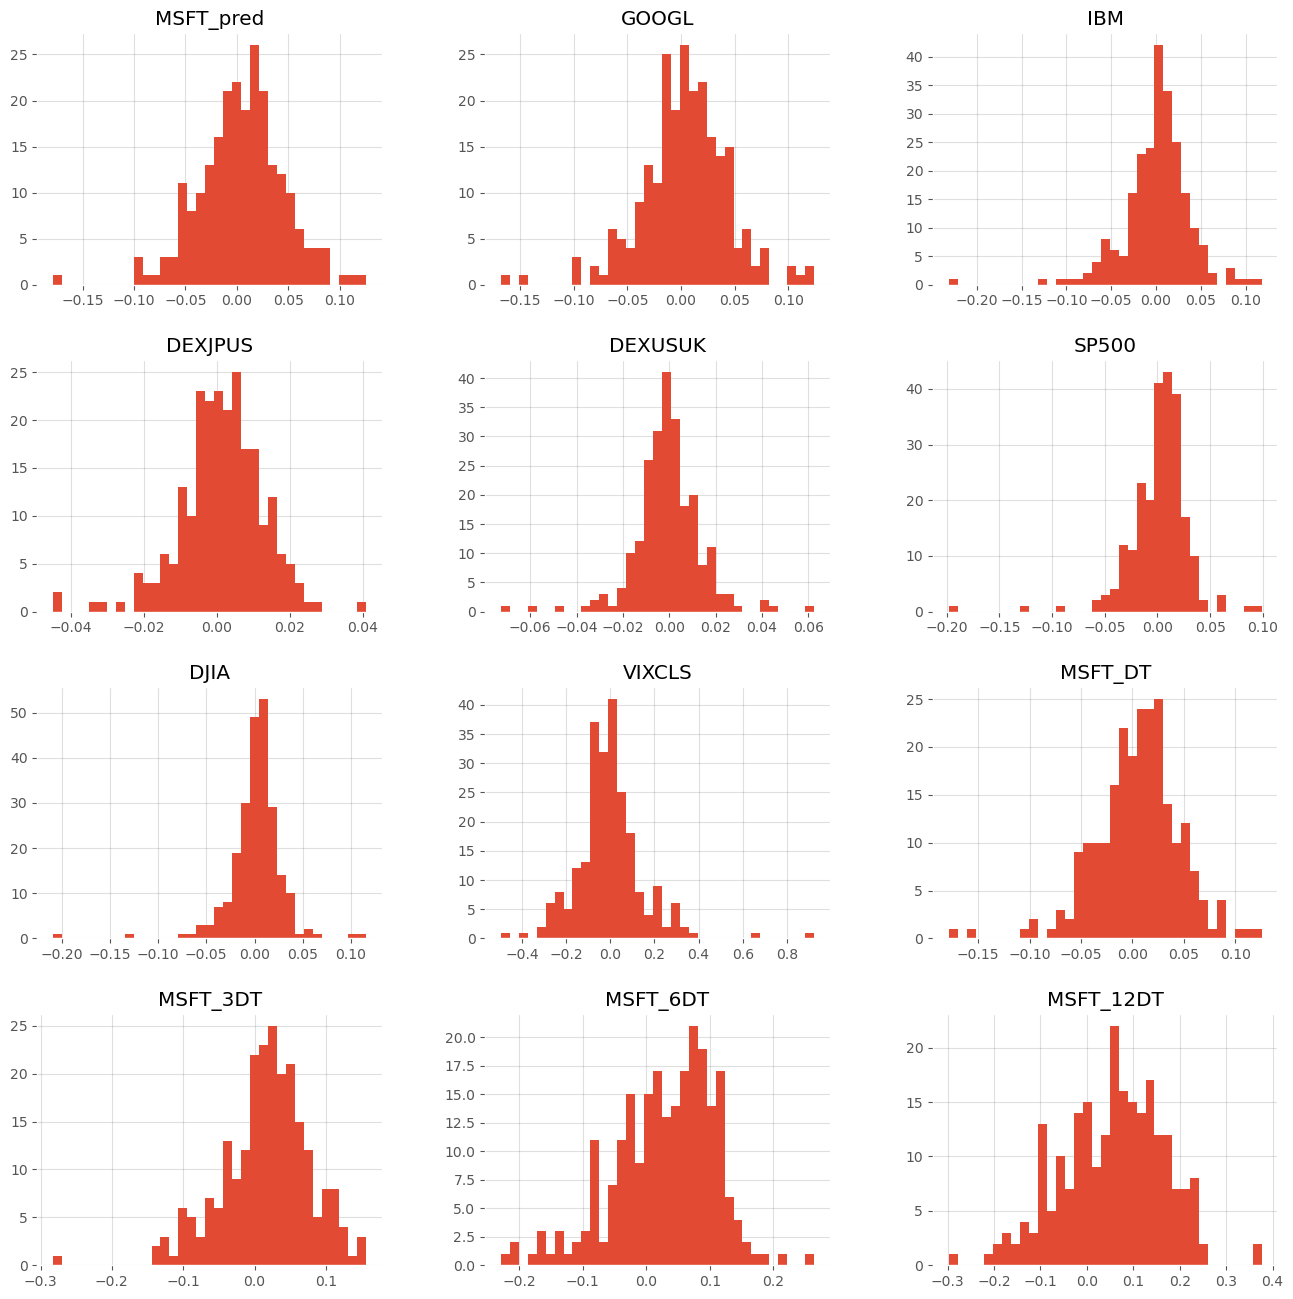

In [27]:
# Team, note that historam is not robust

(data
 .hist(bins = 35,
       sharex = False,
       sharey = False,
       figsize =[16, 16]
      )
)
plt.show()

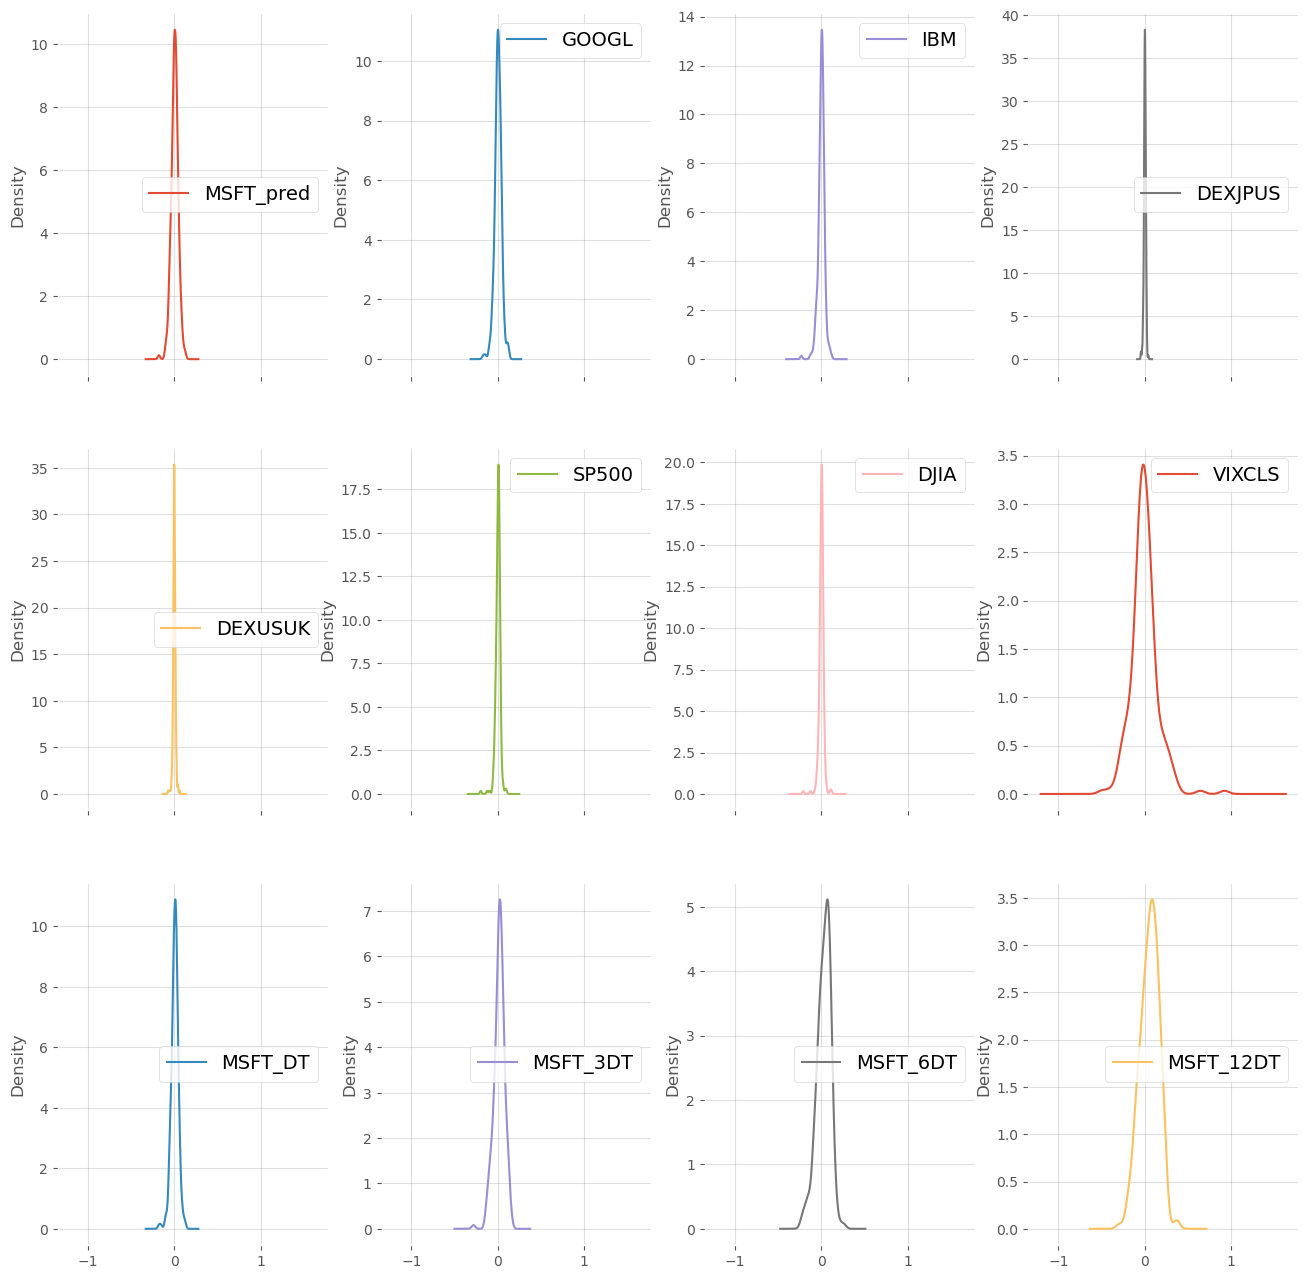

In [28]:
# Team, use this--kernel density estimation

(
    data.
    plot(kind = "density",
         subplots = True,
         layout = (3, 4),
         sharex = True,
         legend = True,
         figsize = [16, 16]
        )
)

plt.show()

<Axes: title={'center': 'Correlation Matrix'}>

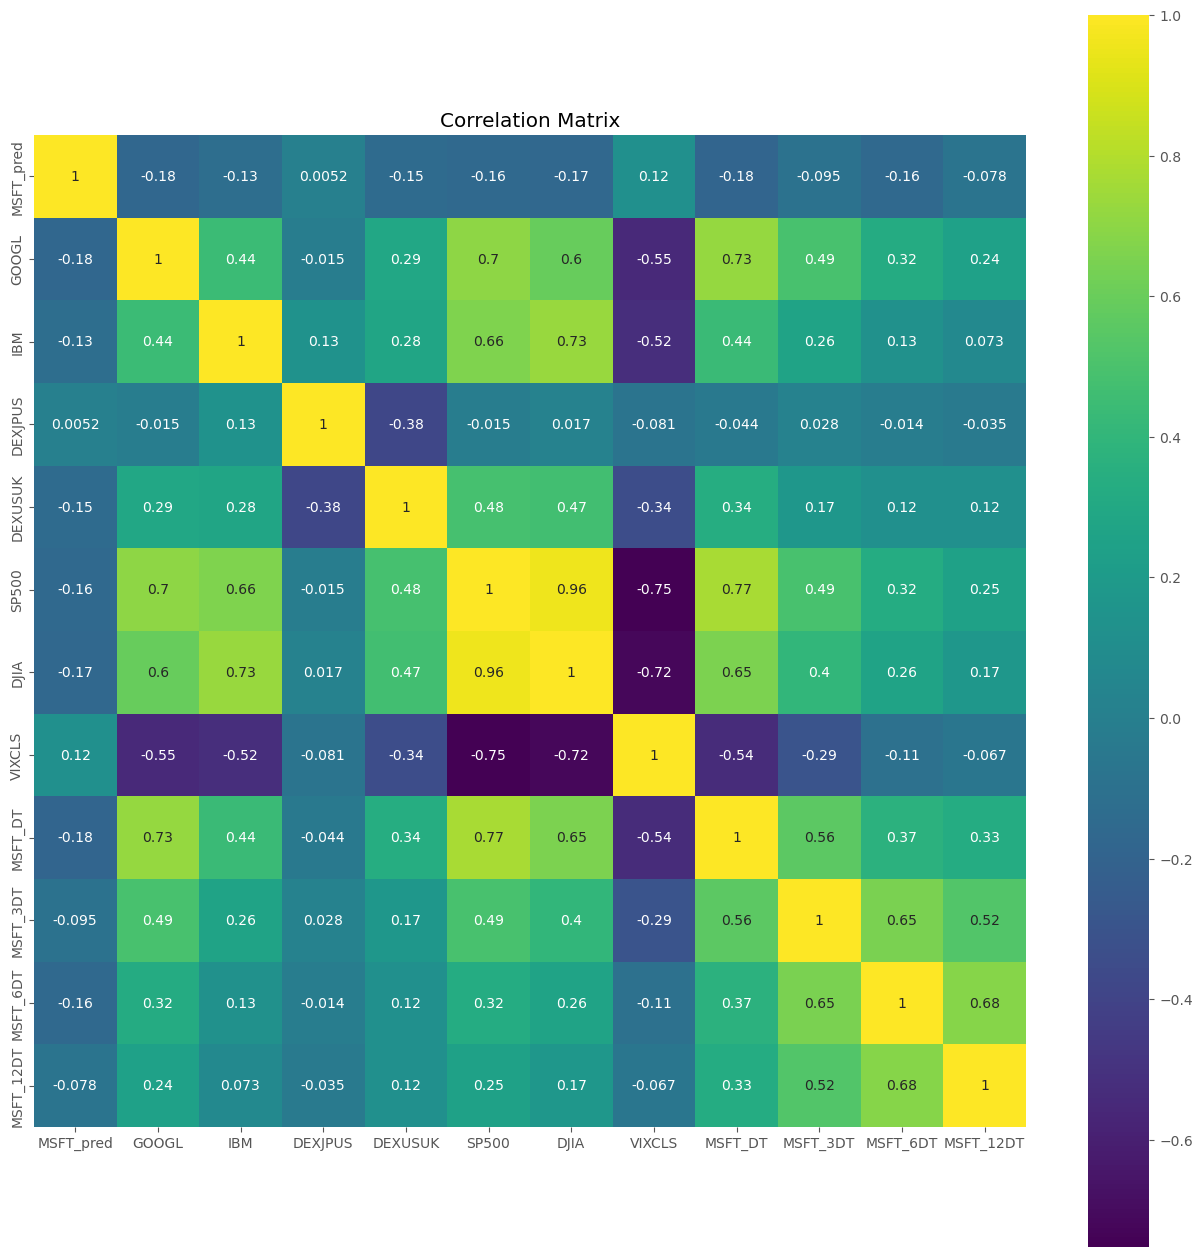

In [29]:
correlation = data.corr()

plt.figure(figsize =[16, 16]
          )

plt.title("Correlation Matrix")

sns.heatmap(correlation,
            vmax = 1,
            square = True,
            cmap = "viridis",
            annot = True)

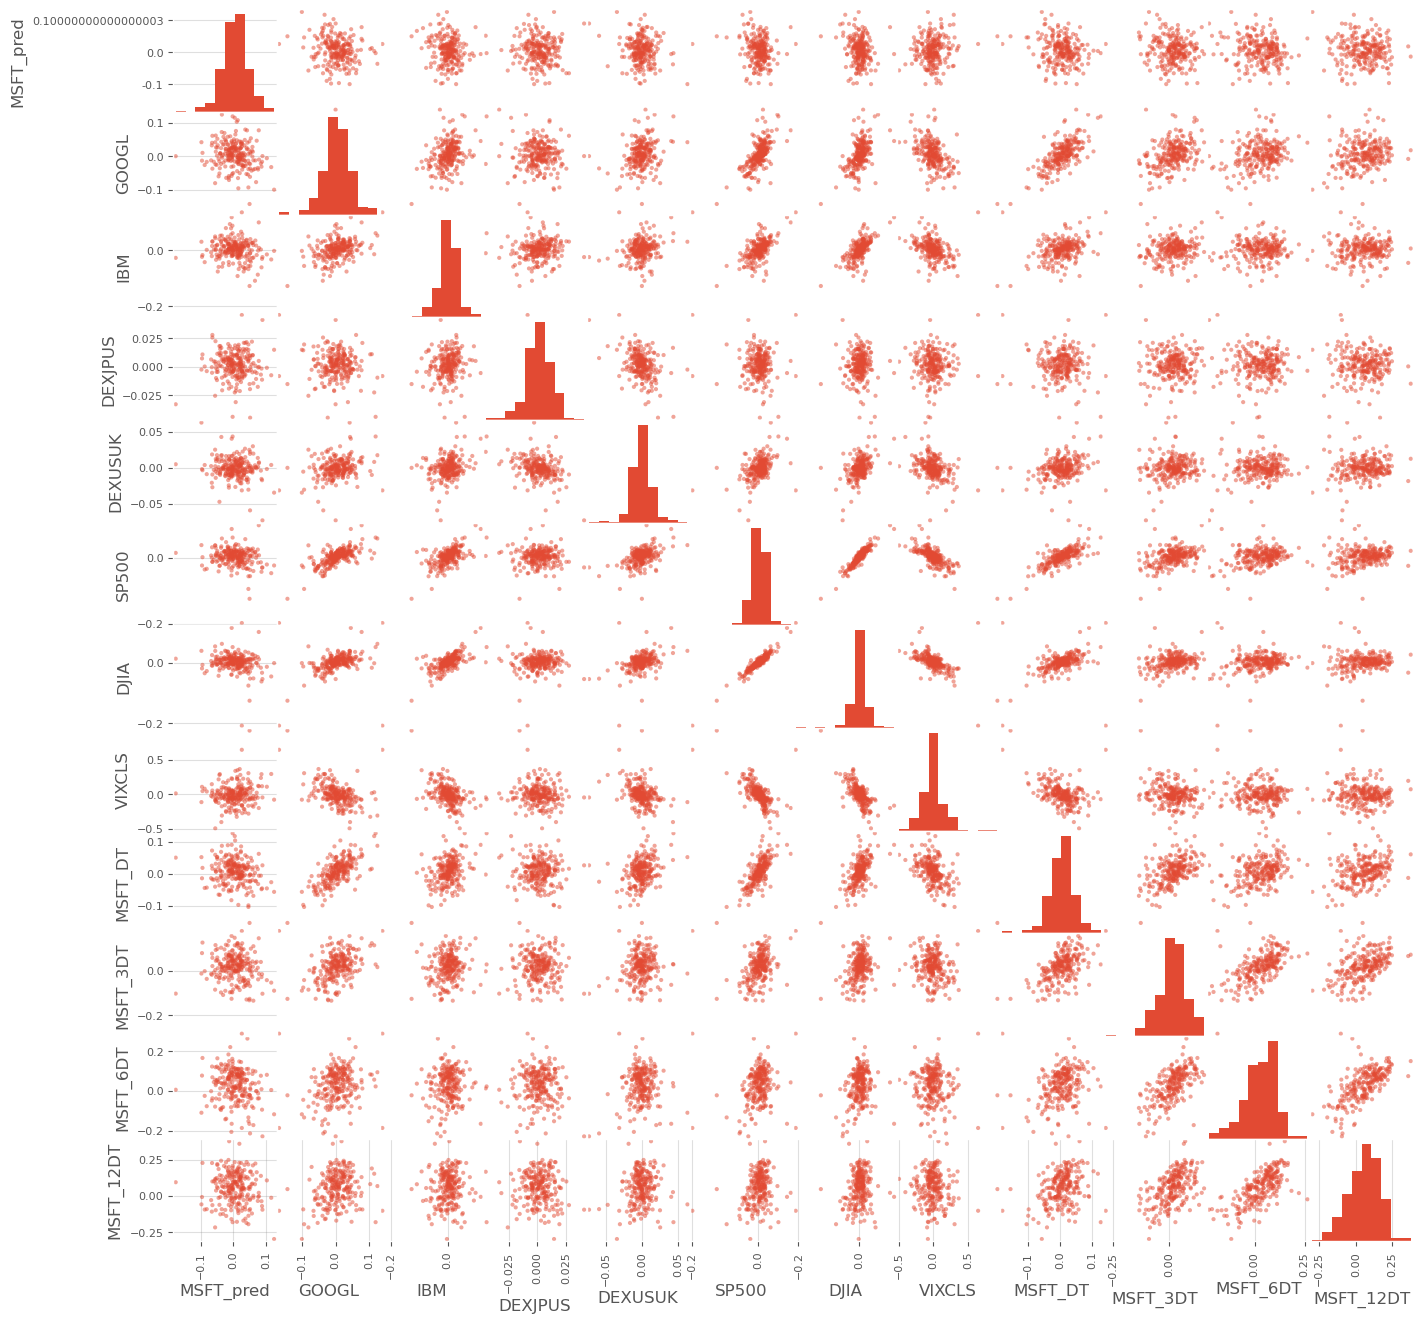

In [30]:
scatter_matrix(data,
               figsize = (16, 16)
              )
plt.show()

## <a id = "p3">3. </a> <font color = "green"> Supervised Machine Learning: A Step-by-Step Guide </font>  [back to table of contents](#top)

### Step 1: Data Split

> Let's partition the original dataset into a training set and a test set.

In [31]:
validation_size = 0.20

train_size =\
    int(len(X) 
        * 
        (1 - validation_size)
       )

X_train, X_test =\
    (X[0         :train_size], 
     X[train_size:len(X)    ]
    )

Y_train, Y_test =\
    (Y[0         :train_size], 
     Y[train_size:len(X)    ]
    )

### Preprations for Step 4: Ten-fold Cross Validation and Evaluation Metrics

In [32]:
num_folds = 10
seed = 230926
scoring = "neg_mean_squared_error"

### Step 3: Fitting: Model Comparison with ML Algorithms

In [33]:
models = []

#### Regression and tree regression algorithms

In [34]:
models.append(("LR", LinearRegression()
             )
            )

models.append(("LASSO", Lasso()
             )
            )

models.append(("EN", ElasticNet()
             )
            )

models.append(("CART", DecisionTreeRegressor()
             )
            )

models.append(("KNN", KNeighborsRegressor()
             )
            )

models.append(("SVR", SVR()
             )
            )

#### Ensemble models

In [35]:
# Bagging (Boostrap Aggregation)

models.append(("RFR", RandomForestRegressor()
              )
             )

models.append(("ETR", ExtraTreesRegressor()
              )
             )

# Boosting

models.append(("GBR", GradientBoostingRegressor()
              )
             )

models.append(("ABR", AdaBoostRegressor()
              )
             )

> Once you have selected all the models, you might want to loop over each of them. 

> First, let’s run the k-fold analysis. Then try to run the model on the entire training and testing dataset.

> All the algorithms use default tuning parameters. We will calculate the mean and standard deviation of the evaluation metric for each algorithm, collecting the results for model comparison.

### Best Practice in ML: Compare Algorithms' Performance

In [36]:
# Gift for you

# Team, let me guide you through this step-by-step

### Initialization of Lists:

names = []

kfold_results = []

train_results = []
test_results = []

# Four empty lists are initialized. 
# names will store the names of the models, 
# kfold_results will store the cross-validation results, 
# train_results and test_results 
# will store the performance of the models 
# on the training and testing datasets, respectively.

### Looping through Models:

# Let's iterate over a list of models. 

# Each element in the models list is a tuple 
# containing the name of the model (name) and the model object (model).

for name, model in models:
    
### Appending Model Names:

# The name of the current model is appended to the names list.

    names.append(name)
    
### Let's run K-fold Cross-Validation
    
    kfold =\
        (KFold(n_splits = num_folds,
               random_state = seed,
               shuffle = True)
        )
    
# A KFold object is created with a specified number of splits (num_folds), 
# a random seed (seed), 
# and shuffling enabled.
    
### Running Cross-Validation:
# Let's convert MSE to positive (Here, now it becomes lower the better; See below)

    cv_results =\
        (
         -1
         *
         cross_val_score(model, X_train, Y_train,
                         cv = kfold,
                         scoring = scoring)
        )
        
# Cross-validation is performed on the training data (X_train, Y_train) using the current model. 
# The negative mean squared error is used 
# as the scoring metric 
# (hence multiplied by -1 to make it ositive, 
# as the convention is that higher scores are better).

# Storing Cross-Validation Results:
 
### The cross-validation results for the current model are appended to the kfold_results list.    
    
    kfold_results.append(cv_results)

# Fitting the Model on the Entire Training Set:
  
    res = model.fit(X_train, Y_train) # The model is trained on the entire training dataset.

### Evaluating Model on Training Set:

# The trained model’s predictions on the training set are evaluated 
# using the mean squared error, and the result is appended to train_results.

    train_result = mean_squared_error(res.predict(X_train), Y_train)
    
    train_results.append(train_result)

## Evaluating Model on Testing Set:    
    
# Similarly, the model’s performance is evaluated 
# on the testing set and appended to test_results.
    
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    
    test_results.append(test_result)
    
# Printing the Results:

# The name of the model, 
# the average cross-validation score, 
# the standard deviation of the cross-validation scores, 
# the training set performance, 
# and the testing set performance are printed out.

    message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), 
                                     cv_results.std(), 
                                     train_result, 
                                     test_result)
    print(message)

LR: 0.001707 (0.000633) 0.001446 0.001970
LASSO: 0.001631 (0.000612) 0.001610 0.001861
EN: 0.001631 (0.000612) 0.001610 0.001861
CART: 0.003007 (0.000699) 0.000000 0.005867
KNN: 0.001960 (0.000774) 0.001290 0.001970
SVR: 0.002571 (0.000422) 0.002371 0.003010
RFR: 0.001736 (0.000699) 0.000249 0.002659
ETR: 0.001775 (0.000748) 0.000000 0.002788
GBR: 0.001979 (0.000656) 0.000183 0.003743
ABR: 0.001792 (0.000667) 0.000976 0.004291


#### Comparing the algorithms by examining the cross validation results

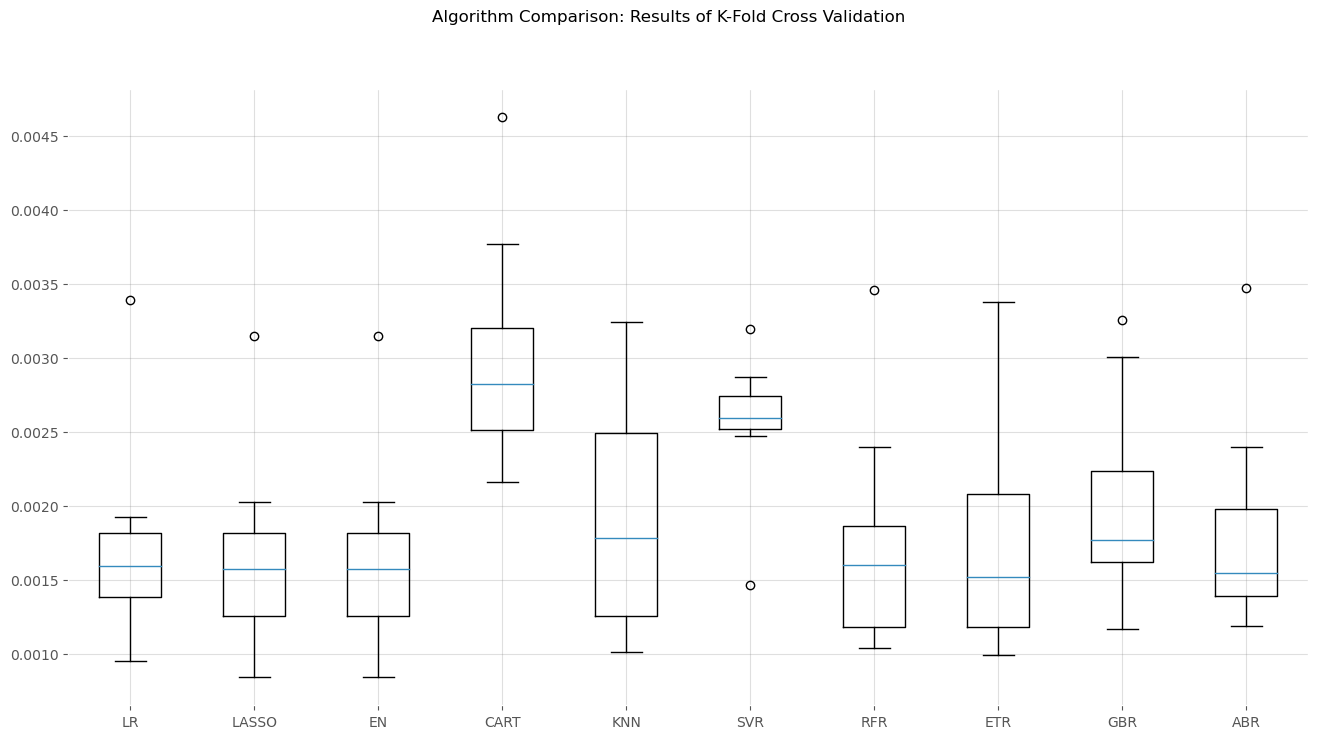

In [37]:
fig = plt.figure(figsize = [16, 8]
                )

fig.suptitle("Algorithm Comparison: Results of K-Fold Cross Validation")

ax = fig.add_subplot(111)

plt.boxplot(kfold_results)

ax.set_xticklabels(names)

plt.show()

### Time Series based models (ARIMA)

> Let us first prepare the dataset for ARIMA models, by having only the correlated variables as exogenous variables.

#### ARIMA

In [38]:
data

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2018-11-02,0.031616,-0.011377,-0.075891,0.012815,0.010779,0.023923,0.023321,-0.213771,-0.007508,-0.031616,-0.073529,-0.028687
2018-11-09,-0.007440,0.005148,0.078480,0.005995,0.001002,0.021058,0.028034,-0.116758,0.031616,0.008340,-0.042875,0.017771
2018-11-20,0.088485,-0.016859,-0.030586,-0.011561,-0.017183,-0.029938,-0.033001,0.115894,-0.045832,-0.015355,-0.094381,-0.070401
2018-11-28,-0.017521,0.057823,0.048302,0.007929,-0.000783,0.034807,0.036196,-0.117723,0.088485,0.035386,0.005391,-0.000985
2018-12-07,0.011477,-0.044843,-0.017773,-0.008313,-0.001802,-0.047138,-0.046055,0.251191,-0.049961,-0.001430,0.028450,-0.059351
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-15,-0.040826,0.007451,-0.011510,0.000880,-0.006756,-0.001610,0.001204,-0.003619,-0.012190,0.031532,0.012954,-0.007949
2023-09-22,-0.003983,-0.053441,0.006282,0.002770,-0.010954,-0.029707,-0.019084,0.220966,-0.040826,-0.033348,-0.016387,-0.055616
2023-09-29,0.035804,0.004672,-0.046037,0.007995,-0.003514,-0.007437,-0.013527,0.018434,-0.003983,-0.056998,-0.003572,-0.075608
2023-10-06,0.001435,0.050078,0.012255,-0.002345,0.003351,0.004758,-0.002986,-0.004003,0.035804,-0.009004,0.022528,-0.043869


In [39]:
data.columns

Index(['MSFT_pred', 'GOOGL', 'IBM', 'DEXJPUS', 'DEXUSUK', 'SP500', 'DJIA',
       'VIXCLS', 'MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT'],
      dtype='object')

In [40]:
# Basic Set-up for ARIMA

X_train_ARIMA =\
    (X_train
    .loc[ : , ["GOOGL", "IBM", "DEXJPUS", "SP500", "DJIA", "VIXCLS"]]
   )

X_test_ARIMA =\
    (X_test
    .loc[ : , ["GOOGL", "IBM", "DEXJPUS", "SP500", "DJIA", "VIXCLS"]]
)    

train_len = len(X_train_ARIMA)
test_len = len(X_test_ARIMA)
total_len = len(X)


* `p` denotes the order of Auto Regression (AR) polynomials

* `d` denotes the number of nonseasonal differences needed for stationarity

* `q` denotes the oder of Moving Average (MA) polynomials


In [41]:
modelARIMA =\
(    stats
     .ARIMA(endog = Y_train,
                exog = X_train_ARIMA,
                order = [1, 0, 0]
            )
)

model_fit = modelARIMA.fit()

E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [42]:
model_fit

In [43]:
# dir(model_fit)

In [44]:
# help(model_fit.fittedvalues)

In [45]:
error_training_ARIMA =\
(    mean_squared_error(Y_train,
                       model_fit.fittedvalues)
)

predicted =\
(
    model_fit
    .predict(start = train_len - 1,
             end = total_len - 1,
             exog = X_test_ARIMA)[1: ]
)

E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [46]:
error_testing_ARIMA =\
(    mean_squared_error(Y_test,
                        predicted)
)

error_testing_ARIMA

0.0020483403878419904

> Let's append to previous results.

In [47]:
test_results.append(error_testing_ARIMA)

train_results.append(error_training_ARIMA)

names.append("ARIMA")

### Comparison of Algorithms: Team, in the field practice, please create something looks like this :)

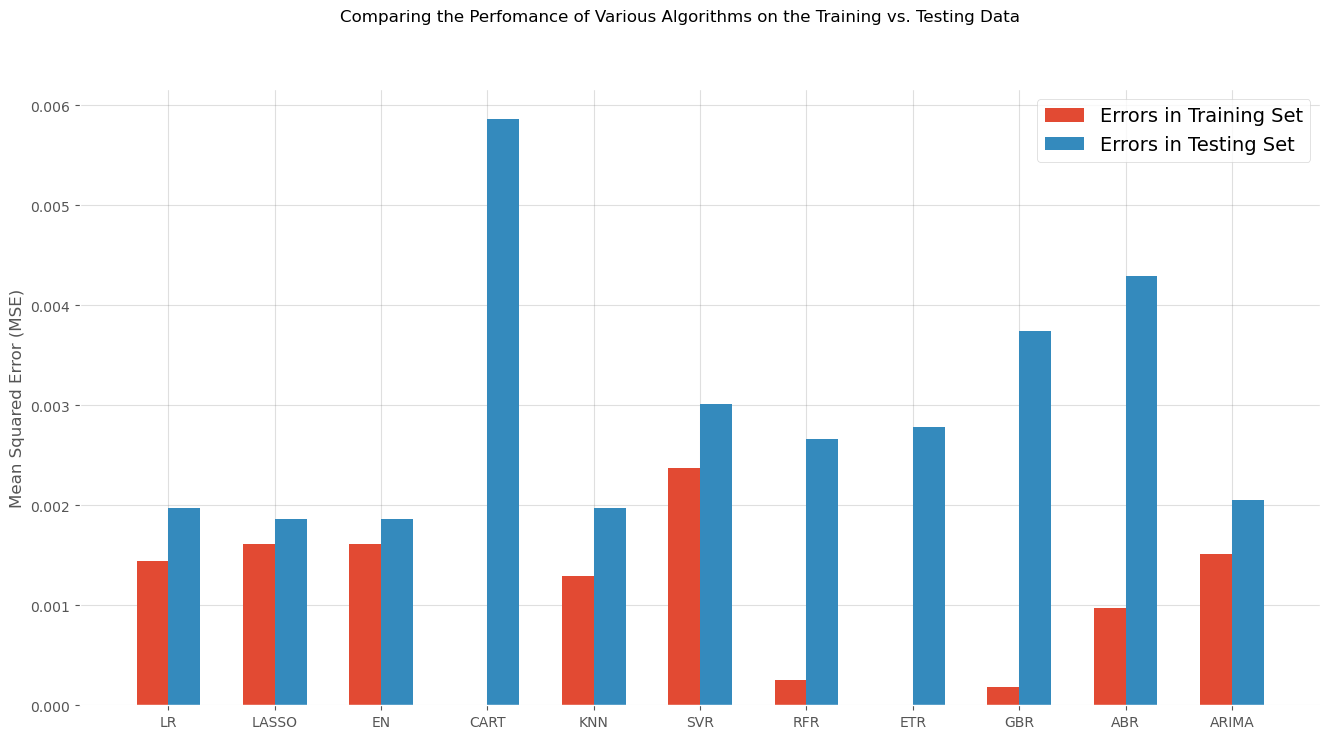

In [48]:
fig = plt.figure(figsize = [16, 8])

ind = np.arange(len(names)
               )

width = 0.30

fig.suptitle("Comparing the Perfomance of Various Algorithms on the Training vs. Testing Data")

ax = fig.add_subplot(111)

(plt
 .bar(ind - width/2,
    
      # Team, this line calculates the starting x position of the bars 
      # representing "Errors in Training Set". 
      # The width/2 term is used to shift the bars to the left, 
      # so they are centered around the tick mark for each group (algorithm) on the x-axis.
      
      # The bar chart will have two sets of bars for each algorithm: 
      # one for training errors and one for testing errors. 
      
      # By subtracting width/2 from ind, 
      # the training error bars are positioned to the left of the center of the tick marks. 
      
      train_results,
      width = width,
      label = "Errors in Training Set")
)

(plt
 .bar(ind + width/2,
      test_results,
      width = width,
      label = "Errors in Testing Set")
)

plt.legend()

ax.set_xticks(ind)
ax.set_xticklabels(names)

plt.ylabel("Mean Squared Error (MSE)")

plt.show()

## <a id = "p4">4. </a> <font color = "green"> An Introduction to Hyperparameter Tuning </font>  [back to table of contents](#top)

### Model Tuning and Grid Search for ARIMA

In [49]:
# Hyperparameter Tuning; Grid Search for ARIMA

def assess_ARIMA_model(arima_order):
    
    modelARIMA = stats.ARIMA(endog = Y_train, 
                             exog = X_train_ARIMA,
                             order = arima_order)
    
    model_fit = modelARIMA.fit()
    
    error = mean_squared_error(Y_train,
                               model_fit.fittedvalues)
    
    return error

def assess_models(p_values, d_values, q_values):
    
    best_score, best_cfg = float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = assess_ARIMA_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    
                    print("ARIMA%s MSE = %.7f" % (order, mse)
                          )
                    
                except:
                    continue
    print("Best ARIMA%s MSE = %.7f" % (best_cfg, best_score)
          )
    
# parameters to use for assessment

p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)

In [50]:
assess_models(p_values, d_values, q_values)

E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 0) MSE = 0.0015151


E:\software\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 1) MSE = 0.0015085
ARIMA(0, 1, 0) MSE = 0.0026710


E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\software\anaconda3\Lib\si

ARIMA(0, 1, 1) MSE = 0.0015586
ARIMA(1, 0, 0) MSE = 0.0015089


E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\software\anaconda3\Lib\si

ARIMA(1, 0, 1) MSE = 0.0015085


E:\software\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0) MSE = 0.0022546


E:\software\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1) MSE = 0.0015746


E:\software\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 0, 0) MSE = 0.0015082


E:\software\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 0, 1) MSE = 0.0015084


E:\software\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 1, 0) MSE = 0.0019865
ARIMA(2, 1, 1) MSE = 0.0015646
Best ARIMA(2, 0, 0) MSE = 0.0015082


E:\software\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [51]:
ARIMA_Tuned =\
    stats \
    .ARIMA(endog = Y_train,
           exog = X_train_ARIMA,
         #  order = [] # Team, input optimal set of hyperparameters here
          )

ARIMA_Fit_Tuned = ARIMA_Tuned.fit()

E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [52]:
ARIMA_Tuned

In [53]:
ARIMA_Fit_Tuned

> Calculate accuracy on testing data

In [54]:
Predicted_Tuned =\
    model_fit \
    .predict(start = train_len - 1,
             end = total_len - 1,
             exog = X_test_ARIMA)[1:]

E:\software\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


- `model_fit` is a fitted ARIMA model instance.
<br>

- `model_fit.predict()` is used to make predictions based on the fitted model.
<br>

- `start=train_len - 1` specifies the starting point of the prediction. Our code is setting it to one less than the length of the training data.
<br>

- `end=total_len - 1` sets the endpoint of the prediction. It is one less than the total length of the dataset, indicating that predictions will be made for the entire testing set.
<br>

- `exog=X_test_ARIMA` refers to exogenous variables, which are external factors that can influence the predictions. X_test_ARIMA is presumably the testing set of these exogenous variables.
<br>

- `[1:]` is used to exclude the first element from the predicted values. It might be done to align the predicted values with the actual values, especially if the prediction includes the last observation from the training set.

In [55]:
print(mean_squared_error(Y_test,
                         Predicted_Tuned)
     )

0.0020483403878419904


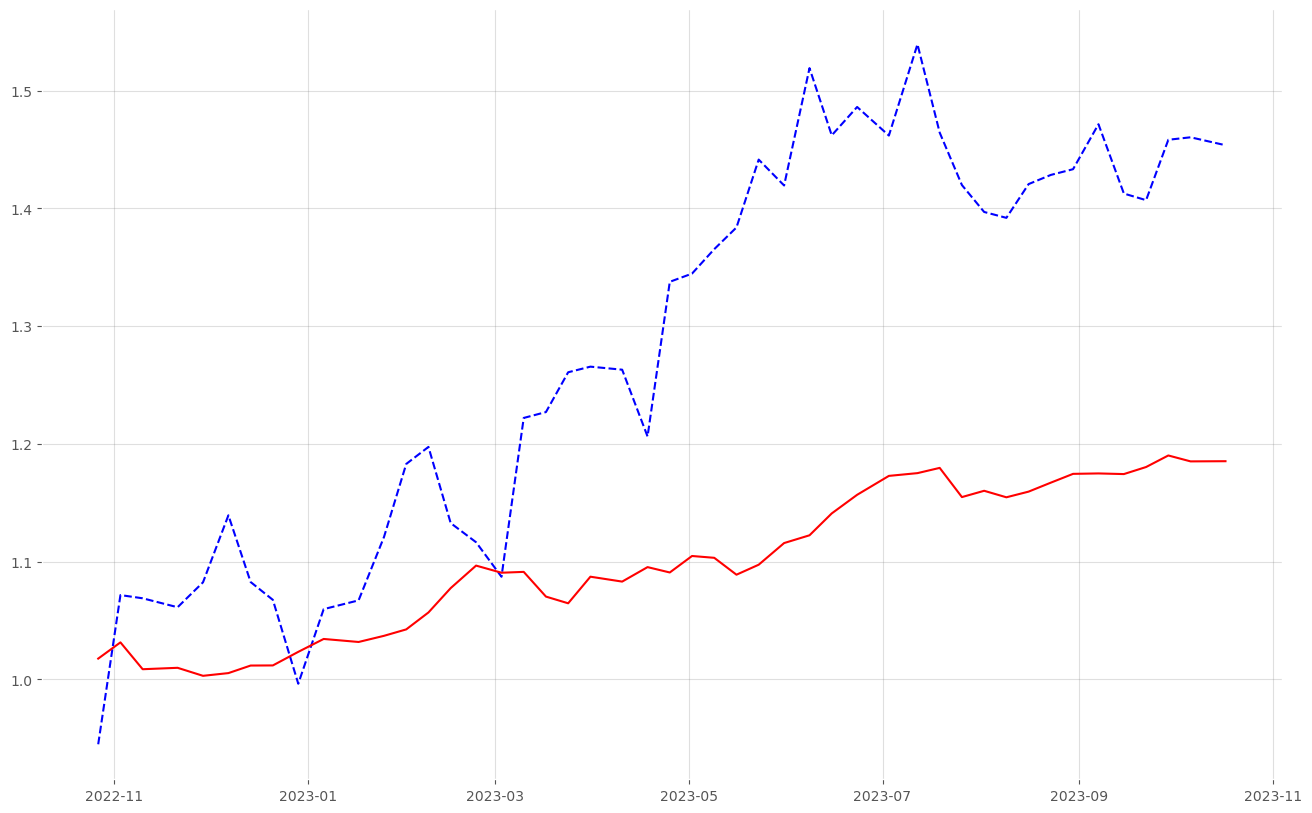

In [56]:
plt.figure(figsize = (16, 10)
           )

Predicted_Tuned.index = Y_test.index

plt.plot(np.exp(Y_test).cumprod(), "b--", label = "Actual Y")

plt.plot(np.exp(Predicted_Tuned).cumprod(), "r", label = "Predicted Y (Y hat)")

plt.show()

## <a id = "p3">5. </a> <font color = "green"> What We Have Learned Thus Far... </font>  [back to table of contents](#top)

### What We Learned from Machine Learning

> It appears that simple models such as linear regression, regularized regression (i.e., Lasso and elastic net), along with time series models such as ARIMA, are promising modeling approaches for asset price prediction problems.

> Such algorithms could help financial practitioners to model time dependencies in a more flexible way. 

> In our problem-solving machine learning lesson, you have learned how to address overfitting and underfitting, which are among the key challenges in prediction problems in computational finance. Do please note that you could use a better set of indicators, such as P/E ratio, trading volume, technical indicators, or news data. To do so might lead to better results (and we will indeed make use of such indicators in following lessons).

> `Thank you for working with the script, Team 👍`